# Prosta Regresja Liniowa

W założeniu modelu liniowego podlegającego superwizji definiujemy dane wejściowe (input) i cele (target), zaś
wagi (weights), błąd systematyczny (bias) i dane wyjściowe (output) pozwalamy wyciągnąć samej maszynie.

### 1. Import bibiliotek

In [1]:
import numpy as np
#Poniższe przyda się do wizualizacji w tym wypadku - TensorFlow ma swój TensorBoard do wizualizacji.
import matplotlib.pyplot as plt   # generator grafów - imho coś jak bokeh.
from mpl_toolkits.mplot3d import Axes3D # wizualizacja ww. w 3D.

In [2]:
LinksDict = { 'metoda' : 'Https://pl.wikipedia.org/wiki/Dok%C5%82adno%C5%9B%C4%87_i_precyzja_metody_pomiaru'
            , 'iloczyn' : 'https://pl.wikipedia.org/wiki/Iloczyn_skalarny'
            , 'błąd' : 'https://pl.wikipedia.org/wiki/B%C5%82%C4%85d_systematyczny'}

In [3]:
### Centrum koordynacji zmiennych ###
observations = 1000  # Tu można zmienić ilość obserwacji. Optymalnie na lapka bez GPU jest 10.000 max. 100.000.
r_v = 10             # Tu ustawiasz sobie poziom szumu w bazie przypadków losowych. Im większa tym większy szum.
v_t = 1              # Tu zmieniasz wartość szumu w danych treningowych.
v_a = 1              # Podstawiasz tu liczbę zmiennych.
rng = 5              # Zakres działania animacji. Jeśli chcesz zobaczyć pełną animację wpisz dużą liczbę np. 200-300.
l_r = 0.02           # Prędkość nauki modelu.



### 2. Generowanie losowych danych do podstawienia do modelu.

In [4]:
xs = np.random.uniform(low = -r_v, high = r_v, size =(observations,v_a)) # funkcja generowania liczb losowych w numpy.
# Od -10 do 10 z równą szansą dla każdej. rozmiar to liczba obserwacji / liczba zmiennych
zs = np.random.uniform(-r_v,r_v,(observations,v_a)) # ta sama funkcja, druga kolumna i bez opisu wewnątrz.

inputs = np.column_stack((xs,zs)) # Ta funkcja łączy dwie kolumny ze sobą - w ten sposób będzie wyglądać input w TF.
# W tym wypadku mamy do czynienia z matrycą 1000x2.

print(inputs.shape) # Drukuje kształt matrycy. Tutaj użyte jako sanity check.

(1000, 2)


### 3. Utworzenie celów do których ma dążyć maszyna

In [5]:
noise = np.random.uniform(-1,1,(observations,1)) # Generuje 'szum' w danych docelowych. 
# Kiedy zapewniamy maszynie próbkę danych to one nigdy nie są idealne i to reprezentuje ten niewielki szum.

targets = 13*xs + 7*zs - 12 + noise # Tę funkcję ma 'odkryć' maszyna ucząc się z naszych danych. 
# W ten sposób mówimy, że wagi mają mieć 2 i -3 a błąd 5. Jest to wektor 1000x1.

print(targets.shape) # Kolejny sanity check, żeby sprawdzić, czy dobrze zdefiniowaliśmy cele.

(1000, 1)


### 4. Tworzenie grafu 3D dla podglądu danych treningowych

Chodzi tu o to, żeby zobaczyć na wykresie czy występuje tu trend jaki chcieliśmy uzyskać.

In [6]:
def graph_animator(var, observations, targets,):
    # Używanie matplotlib - typowa składnia.

    # Zadeklarowanie grafu
    fig = plt.figure()

    # Metoda tworząca graf 3d
    ax = fig.add_subplot(111, projection='3d')

    # Dobór osi
    ax.plot(xs, zs, targets)

    # Dobór nazw osi.
    ax.set_xlabel('xs')
    ax.set_ylabel('zs')
    ax.set_zlabel('Targets')
    

    # Azymut pozwala oglądać dane z różnych stron. Można się tym pobawić. Np. azim = 0 lub 200.
    ax.view_init(azim = 120 + var)

    # Pokaż graf.
    print(var)

    plt.show()

0


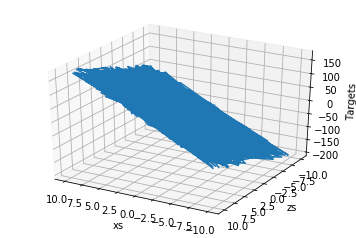

1


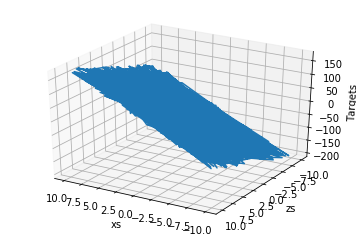

2


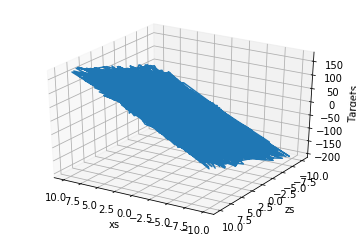

3


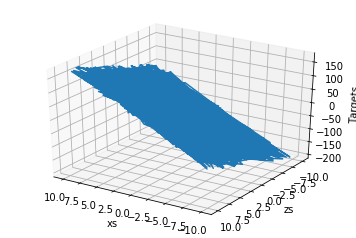

4


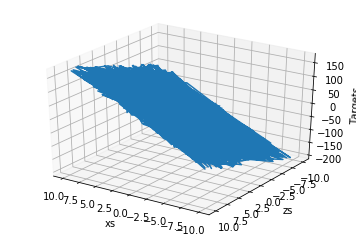

In [7]:
# To taka moja mała animacja ad-hoc, bo lubię widzieć co się dzieje w środku, 
    # a tak znacznie łatwiej to sobie zwizualizować. :P
    # Jak masz przedpotopowy sprzęt jak ja i nie masz GPU (karty graficznej), którą
    # dałoby się taki proces przysipieszyć, to polecam nie odpalać navigatora anakondy,
    # a najlepiej w ogóle zrezygnować ze środowiska graficznego i poruszać się po systemie przy pomocy basha.
    # Naturalnie jeśli Twój komputer nie dostaje zadyszki przy milionie rekordów w bazie, to pewnie
    # nie masz się czym przejmować. Ja zbieram teraz na jakiś porządny sprzęt z kartami "tesla" albo na ten procesor
    # co to ma być tylko do obsługi SI a jednak bardziej wydajny niż GPU.

    # Używamy .reshape żeby przygotować cele pod graf.
    # reshape jest w docsach do numpyego. Jako argumenty przyjmuje wymiary, którymi chcemy opisać obiekt.
targets = targets.reshape(observations,)

#Ta funkcja powiela graf tyle razy ile tego sobie życzę.
for i in range(rng): #Zmień to sobie na większą wartość jeśli masz zasoby i chcesz z tego zrobić 'animację'.
                   #Ja wpisałem 300 i obracało się całkiem nieźle.
    graph_animator(i,observations,targets)
    
# Przywracamy poprzedni kształt celom, żeby można ich ponownie użyć do nauki.
# Równie dobrze można było je przepisać na nową zmienną np. 'targets_plot' i teraz tego nie robić
# ale warto znać i metodę odwrotną tak na wszelki wypadek. Pytanie co jest mniej zasobochłonne.
targets = targets.reshape(observations,1)

### 5. Inicjalizowanie zmiennych

In [8]:
# Stała (init_range). Podstawnik do funkcji generującej losowo początkowe wagi i obciążenia, dla modelu.
    # (init_range) to wartość odchylenia od zera w ramach którego sprzęt losuje nam ww. wartości początkowe.
    # Algorytm może się zawiesić jeśli nadamy 'init_range' zbyt dużą wartość| POMOC? Ostatnia działająca wartość: 0.1.
        # Można rzecz jasna eksperymentować z tą wartością i zachęcam do tego. 
        # Niemniej uważam, że najlepiej radzi sobie pozostawiona w spokoju...
init_range = 0.1

#?# ILE WAG #?# powinien zawierać mój model? || Pokrótce: ilość_wag_w_modelu = wejścia.ilość * ujścia.ilość #!#
    # || Dokładnie: Wagi mają wymiar k * m, gdzie k to ilość[zmiennych-wejściowych] (tutaj: dwie - x,z), 
    # || a m to ilość[zmiennych-wyjściowych], (tutaj: jedna - y). Logicznie matryca wag ma u nas wymiar 2x1.
weights = np.random.uniform(low=-init_range, high=init_range, size=(2, 1))

#?# ILE BŁĘDÓW #?# systematycznych wziąć pod uwagę? || Krótko: błędy_sys_w_modelu.ilość = ujścia.ilość #!#
    # || Dłużej: Mamy jeden błąd systematyczny, gdyż jest tylko jedno ujście funkcji. Błąd systematyczny to skalar.
biases = np.random.uniform(low=-init_range, high=init_range, size=1)

In [9]:
# Funkcja ujednoznaczniająca, opisuje aktualny stan wag i obciążeń***. + Sanity check.
def pretty_weights():
    wagi = "wagi: %s" % weights
    obci = "obciążenia: %s" % biases
    print (wagi)
    print (obci)

In [10]:
# *** inaczej: 'błędów systematycznych'
print(LinksDict['błąd'])

https://pl.wikipedia.org/wiki/B%C5%82%C4%85d_systematyczny


In [11]:
pretty_weights()

wagi: [[-0.06323971]
 [-0.01890722]]
obciążenia: [0.07753753]


### 6. Ustalanie prędkości uczenia się modelu

Ogólnie przy MNIST od Hindusa używałem 0.01 i strasznie muliło, ale w 30 krokach robiło robotę.
Warto się z tym pobawić. Zwłaszcza przy prostszych modelach, albo mocniejszych maszynach.
Ostatecznie zawsze można przerwać operacje i zmienić wartość na większą a mniej dokładną.

In [12]:
learning_rate = l_r # Dla mnie najlepsze osiągi dawała baza 10.000 rekordów i czułość 0.03-0.04.

In [13]:
# Wykonujemy 100 iteracji na naszym zestawie treningowym. Do ww parametrów było jak znalazł.
    # Ogólnie rzecz biorąc jest to nieco bardziej skomplikowane i jeszcze się tym zajmiemy,
    # ale to co musimy na tym etapie wiedzieć, to to, że wzraz ze wzrostem prędkości_uczenia potrzebujemy mniej iteracji,
    # podczas gdy wraz jej spadkiem ilość iteracji potrzebnych do osiągnięcia podobnych wyników wzrasta.
        # Miej również na względzie, że zbyt wysoka prędkość nauki (learning_rate) może sprawić, 
        # że strata będzie dążyć do nieskończoności, zamiast do zera.
for i in range (100):
    
# To jest równanie modelu liniowego: y = xw + b
    # Tzn. ujścia = żródła * wagi + obciążenia.
    outputs = np.dot(inputs,weights) + biases
# Delty (deltas) to różnice pomiędzy ujściami i celami.
    # Zwróć uwagę, że tutaj delty są wektorami 1000 x 1.
    deltas = outputs - targets
    
# Bierzemy się za normę straty L2, którą dzielimy przez 2 i jeszcze przez liczbę obserwacji.
    # Chodzi tu po prostu o przeskalowanie przez stałą. Taka operacja nie zmienia logiki optymalizacji,
    # gdyż każda funkcja, która jako swoją podstawową właściwość ma to, że traci na wartości,
    # w miarę poprawiania się wyników modelu (i vice-versa tj. przy wzroście wartości funkcji wyniki się pogarszają)
    # MOŻE być użyta jako funkcja straty. Tj. liczą się tu proporcje różnic a nie wartości bezwzględne.
    loss = np.sum(deltas ** 2) / 2 / observations
    
    # Przy każdej iteracji zwracamy funkcję straty, dzięki czemu mamy podgląd na to czy spada tak jak oczekujemy.
    print (loss)
    
# Delty również podlegają skalowaniu w taki sam sposób jak funkcja straty.
    # Mam na myśli, że w ten sposób można prędkość nauki (learning_rate) ooderwać od ilości przypadków (observations)
    # To znowu nie zmieni to logiki działania programu, ale z kolei ułatwia dobrać pojedynczą prędkość nauki
    # która pozostanie taka sama, bez względu na ilość próbek (observations).
    # Możesz spróbować rozwiązać ten problem bez przeskalowywania i zobaczyć jak Ci to odpowiada.
    deltas_scaled = deltas / observations

# Koniec końców stosujemy zasadę aktualizacji gradientu prostego. Wagi to 2x1, prędkość uczenia się jest skalarem,
    # źródła są 1000x2 a wyskalowane delty (deltas_scaled) 1000x1.
    # Transponujemy źródła (co jest dozwolone), aby móc wykonać operację tj będą teraz 2x1000. To  skraca się
    # z 1000x1 i mamy 2x1.
    # wagi = wagi - prędkość_nauki x iloczyn_skalarny**
    weights = weights - learning_rate * np.dot(inputs.T,deltas_scaled)
    # obciążenia = 
    biases = biases - learning_rate * np.sum(deltas_scaled)
    
    # Wagi są aktualizowane zgodnie z zasadami algebry liniowej (macierz minus inna macierz)
    # Mamy jeden błąd systematyczny, a zatem musimy przetransformować delty na skalar (deltas_scaled).
    # Obydwie linijki są zgodne z metodologią gradientu prostego.

3672.1757549951553
479.5690765640219
115.24175497241035
71.17006922934844
63.80061756263746
60.7593432009448
58.30909111375017
56.01094624797918
53.80996859289202
51.696505359278554
49.66640845855286
47.71630834951824
45.84304279542273
44.04358326533521
42.31502167477383
40.65456465604824
39.05952891637178
37.52733688570975
36.05551254943387
34.64167744684204
33.28354682754572
31.978925959320744
30.725706581430565
29.52186349768757
28.365451303746166
27.25460124333925
26.18751818837742
25.16247773803126
24.177823432107957
23.23196407422034
22.323371160421342
21.450576409149406
20.612169388492898
19.80679523693921
19.033152473925497
18.28999089665256
17.576109559763438
16.890354834621867
16.231618545054147
15.598836176542012
14.99098515597265
14.407083199165626
13.846186723506642
13.307389323122804
12.789820304135255
12.292643277622327
11.815054808019244
11.356283114770296
10.915586825135346
10.492253776135273
10.085599863700109
9.694967937160447
9.319726737295118
8.959269876219606
8.61

In [14]:
# **Ależ służę uprzejmie:
print(LinksDict['iloczyn'])

https://pl.wikipedia.org/wiki/Iloczyn_skalarny


In [15]:
# Zwracamy wagi i obciążenia, żebyśmy mogli zobaczyć na ile otrzymaliśmy to co chcieliśmy.
# Gdy deklarowaliśmy cele, wiedzieliśmy, że wagi powinny mieć odpowiednio 13 i 7 a obciążenie 10.
pretty_weights()

# Krócej, choć nieco mniej czytelnie byłoby wstawić: "print(weights, biases)"
# Może być tak, że funkcja nie osiągnąła jeszcze minimum i potrzeba jej więcej iteracji.

wagi: [[12.98256886]
 [ 7.01263606]]
obciążenia: [-10.35994504]


### 7. Jaka jest (ko)relacja wyników do celów?

Sprawdzamy, czy model mierzy to co miał mierzyć.
tj. sprawdzamy jego dokładność* 

Im bliżej mu do linii pod kątem 45* tym bardziej liniowa jest zależność
między celami a wynikami zwracanimy przez funkcję.

*Poniżej link wiki pt. "Dokładność i precyzja metody pomiaru" dla dociekliwych:

In [16]:
print(LinksDict['metoda'])

Https://pl.wikipedia.org/wiki/Dok%C5%82adno%C5%9B%C4%87_i_precyzja_metody_pomiaru


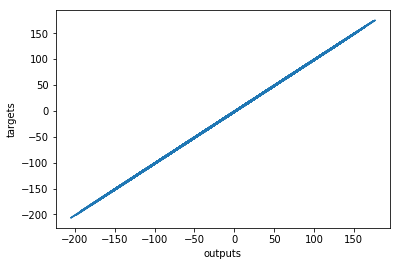

In [17]:
# Zwracamy ujścia i cele aby zobaczyć czy jest między nimi liniowa zależność. (patrz : "Dokładność metody pomiaru")
    # Wizualizacja nie jest tu konieczna, a potem nawet nie będzie możliwa do wykonania,
    # ale ogólnie warto wiedzieć jak ją wykonać, oraz co tutaj sprawdzamy i jak to wygląda na grafie.
plt.plot(outputs,targets)
plt.xlabel('outputs')
plt.ylabel('targets')
plt.show()